In [1]:
# Libraries
import warnings
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import (cross_val_score, train_test_split, StratifiedKFold)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, r2_score, mean_squared_error, mean_absolute_error
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [2]:
df = pd.read_csv("master.csv")

In [3]:
df.rename(columns={"suicides/100k pop":"suicides/100k_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($) ":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)
print(df.columns)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k_pop', 'country-year', 'HDI_for_year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')


In [4]:
df["gdp_for_year"] = df["gdp_for_year"].str.replace(",","").astype(np.int64)
df["age"] = df["age"].str.replace("5-14 years","05-14 years")

In [5]:
df

,country,year,sex,age,suicides_no,population,suicides/100k_pop,country-year,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,63067077179,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,63067077179,2309,Silent
27817,Uzbekistan,2014,male,05-14 years,60,2762158,2.17,Uzbekistan2014,0.675,63067077179,2309,Generation Z
27818,Uzbekistan,2014,female,05-14 years,44,2631600,1.67,Uzbekistan2014,0.675,63067077179,2309,Generation Z


Let's see the performance of sex. 

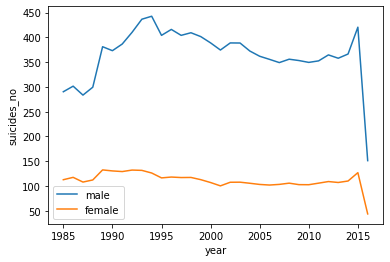

In [6]:
df_men = df[df.sex == "male"]
df_women = df[df.sex == "female"]
sns.lineplot(x=df_men.year, y=df.suicides_no, ci = None)
sns.lineplot(x=df_women.year, y=df.suicides_no, ci = None)
plt.legend(["male", 'female'])
plt.show()

##### From the graph, no matter which year it is, the suicide number of male are about three times higher than of female.

C:\Users\Williams\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


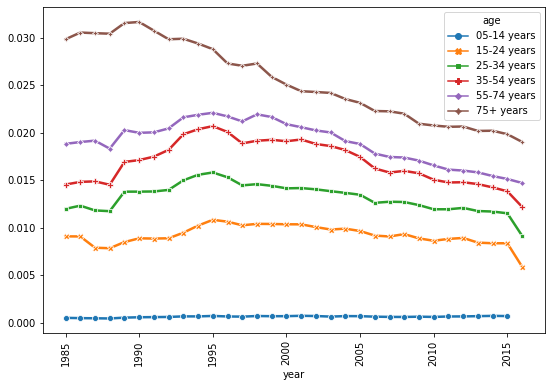

In [7]:
df_age = df.groupby(["year","age"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(9,6))
sns.lineplot(x="year", y=(df_reset.suicides_no*100/df_reset.population), hue = "age",
             data = df_reset, linewidth = 2.5, style = "age", markers=True
            , dashes=False)
plt.xticks(rotation = 90)
plt.show()

###### Obviously, the suicide rate is getting higher when the age is higher. That is, age is a factor of suicide. 

C:\Users\Williams\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


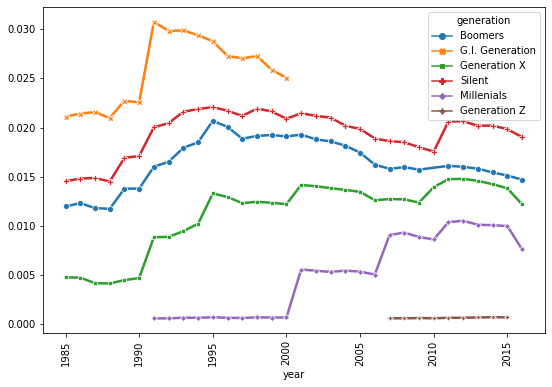

In [8]:
df_generation = df.groupby(["year", "generation"])["suicides_no", "population"].sum()
df_generation_reset = df_generation.copy().reset_index()
plt.figure(figsize=(9,6))
sns.lineplot(x="year", y=df_generation_reset.suicides_no*100/df_generation_reset.population, hue = "generation", 
            data = df_generation_reset, linewidth = 2.5, style = "generation", markers=True
            , dashes=False)
plt.xticks(rotation = 90)
plt.show()

Before 2000, we can see that the highest suicide rate is G.I. generation, and this generation is also known as WW2 generation. They suffered from the worldwide great depression before WW2, at this time, the income, profit, taxes are decreased seriously, so this generation experienced economic and social turmoil.

Did this kind of social impact affect the suicide rate of G.I. generation? Compare to the Silent generation after 2000, the suicide rate is not that high. 

Interestingly, the suicide rate of Generation X and Millenials increase step by step. Besides, the suicide rate increases rapidly once the average age of generation is over 20. Does it mean that the suicide rate of young persons rise when they are independent of their parents? In other words, healthy family is helpful to the suicide rate. Let's take a look.

In [9]:
df["country"].nunique()

101

In [10]:
df["country"].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

###### We found that there are four country names are different, so we rename these names.

In [11]:
df.replace("Republic of Korea", "Korea, Republic of", inplace = True)
df.replace('Czech Republic', "Czechia", inplace = True)
df.replace('Macau', 'Macao', inplace = True)
df.replace('Saint Vincent and Grenadines', "Saint Vincent and the Grenadines", inplace = True)

###### Calcuate the suicide rate for each year, and then take the average of number as rate.

In [12]:
df_suino = df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suino.sort_index(ascending=True)[:] * 100

df_pop = df.groupby(["country","year"]).population.sum()
df_pop_sum = df_pop.sort_index(ascending=False)[:]

df_total = df_sum / df_pop_sum
df_total.head(10)

country  year
Albania  1987    0.002694
         1988    0.002279
         1989    0.002426
         1992    0.001665
         1993    0.002600
         1994    0.001755
         1995    0.003031
         1996    0.003027
         1997    0.005710
         1998    0.005112
dtype: float64

In [13]:
country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

##### For top 10, seven tenth were former Soviet Union countries, located in eastern europe and Russia. Japan and Korea are also high-suicide-rate countries. Let's talk about the disintegration of Soviet Union.

###### Firstly, see what happened to the suicide rate year by year.

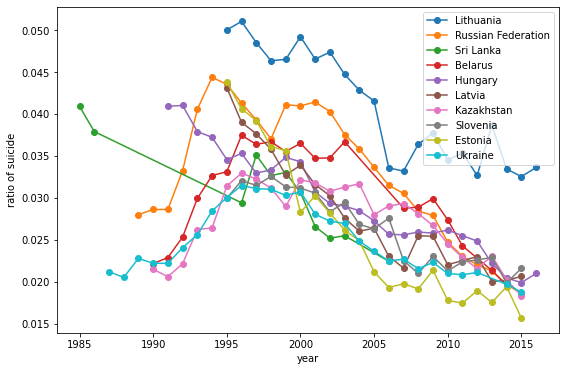

In [14]:
plt.figure(figsize = (9,6))
for country in country_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("ratio of suicide")
plt.legend()
plt.show()

###### It's clearly that the suicide rate of some top10 countries dramatically increased after 1990. In addition, the rate in others are still high during 1990 to 2000. The transition to the economy and democracy in former Soviet Union countries may be the main reasons. Although there have been numerous studies of the increase in mortality, such as alcoholism, economic hardship, despression and so on, but there is still no one accepted as the most significant factor of the mortality crisis. Let's find out.

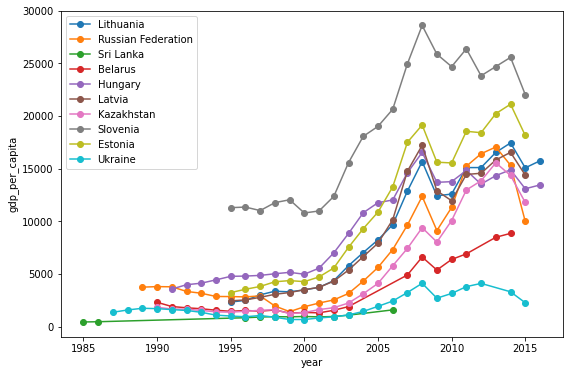

In [15]:
plt.figure(figsize = (9,6))
df_gdp = df.groupby(["country","year"]).gdp_per_capita.mean()
for country in country_list[:10]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("gdp_per_capita")
plt.legend()
plt.show()

###### From this image we can see that the gdp_per_capita has no differece during 1990 to 2000. In other words, the economic situation were remain stagnant and  some countries got worse until 2002, after 2005, all countries' gdp start growing. 

###### We also know that the whole gdp_per_capita dropped within 2008 because of the financial crisis.  However, these ratio were still better than that before 2000. To see the relationship between suicide rate and gdp_per_capita, we plot the regression plot of two parameters. 

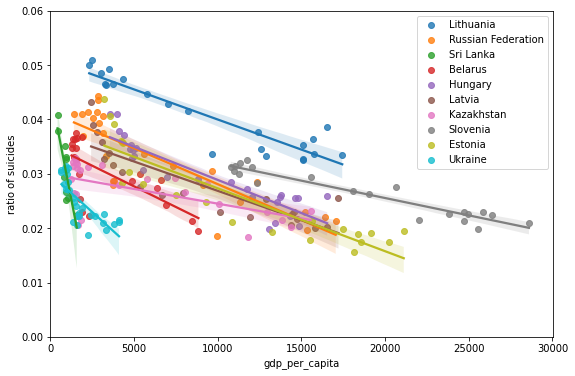

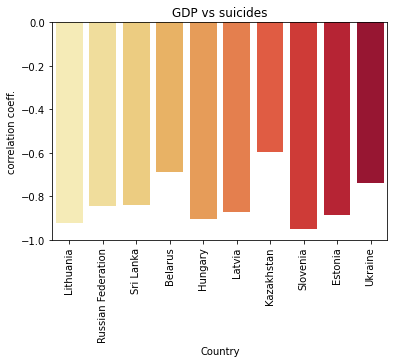

In [16]:
plt.figure(figsize = (9,6))
for country in country_list[:10]:
    sns.regplot(x=df_gdp[country].values, y=df_total[country].values, label = country)
plt.xlabel("gdp_per_capita")
plt.ylabel("ratio of suicides")
plt.ylim(0,0.06)
plt.xlim(0)
plt.legend()
plt.show()

corr_eff = {}
for country in country_list[:10]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

###### Amazing! The suicide rate is highly correlated to the gdp_per_capita of top10 countries. Let's find out whether others have the same trend. 


C:\Users\Williams\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Williams\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Williams\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


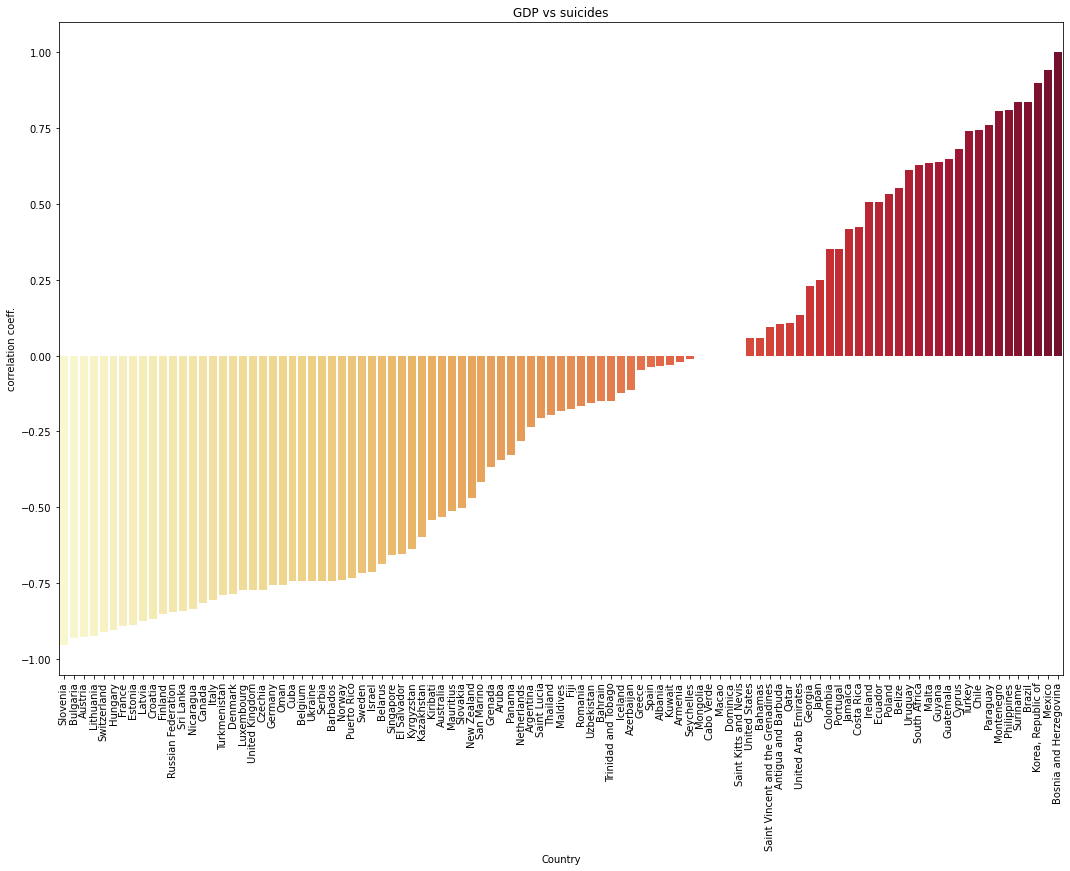

In [17]:
corr_eff = {}
p_value_eff = {}
for country in country_list[:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values, df_total[country].values)
    corr_eff[country] = float(r_value)
    p_value_eff[country] = float(p_value)

gdp_tup = list(corr_eff.items())
gdp_tup.sort(key= lambda pair:pair[1], reverse = False)
dgp_relation = {a[0]:a[1] for a in gdp_tup}

plt.figure(figsize=(18,12))
sns.barplot(x=list(dgp_relation.keys()), y=list(dgp_relation.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

###### Lots of countries' suicide rate are negatively high related to gdp_per_capita, but there are some countries have opposite outcome. It's impressive.

###### Next, we calculate how many countries with correlation coefficient below -0.6 . 

In [18]:
high_relation_gdp = {a:b for a,b in dgp_relation.items() if b <= -0.6}
print(len(high_relation_gdp))
high_relation_gdp

36


{'Slovenia': -0.9529455791278115,
 'Bulgaria': -0.9287679102475702,
 'Austria': -0.9259200512084547,
 'Lithuania': -0.9239757987267332,
 'Switzerland': -0.9109503853299821,
 'Hungary': -0.90403545336273,
 'France': -0.8910330162199881,
 'Estonia': -0.8871441228139314,
 'Latvia': -0.8730699831833396,
 'Croatia': -0.8688905854455011,
 'Finland': -0.8510603475107353,
 'Russian Federation': -0.8447320241371793,
 'Sri Lanka': -0.8423723520534465,
 'Nicaragua': -0.8339461195785589,
 'Canada': -0.8137269827924934,
 'Italy': -0.8058989652804355,
 'Turkmenistan': -0.7897984703898727,
 'Denmark': -0.785030750255649,
 'Luxembourg': -0.7712677174711061,
 'United Kingdom': -0.7709229981372079,
 'Czechia': -0.7706689026781656,
 'Germany': -0.7567584036061585,
 'Oman': -0.7547353920453065,
 'Cuba': -0.7437036777206897,
 'Belgium': -0.7416790406841788,
 'Ukraine': -0.7413562367777868,
 'Serbia': -0.7411928190991897,
 'Barbados': -0.7409526707249006,
 'Norway': -0.7406431335510839,
 'Puerto Rico': -0.7

###### About one third countries have high relationship with gdp_per_capita. We can say that gdp is another reason of high suicide rate.

###### Following are the countries which relation coefficient are higher than 0.6 .

In [19]:
positive_relation_gdp = {a:b for a,b in corr_eff.items() if b > 0.6}
positive_relation_tup = list(positive_relation_gdp.items())
positive_relation_tup.sort(key= lambda pair:pair[1], reverse = True)
positive_relation = {a[0]:a[1] for a in positive_relation_tup}
print(len(positive_relation))
positive_relation

16


{'Bosnia and Herzegovina': 0.9999999999999999,
 'Mexico': 0.9392731898535472,
 'Korea, Republic of': 0.8967892885653611,
 'Brazil': 0.8356111067311864,
 'Suriname': 0.8333078326024657,
 'Philippines': 0.8099497394094539,
 'Montenegro': 0.8042382321252367,
 'Paraguay': 0.7599968993976424,
 'Chile': 0.7412265208253951,
 'Turkey': 0.739878981842937,
 'Cyprus': 0.6812947745988278,
 'Guatemala': 0.6460477591267608,
 'Guyana': 0.6379567025207802,
 'Malta': 0.6334189190517481,
 'South Africa': 0.6287573335302012,
 'Uruguay': 0.6120604681710499}

###### Let's take a look at suicide rate and gdp_per_capita of these countries.

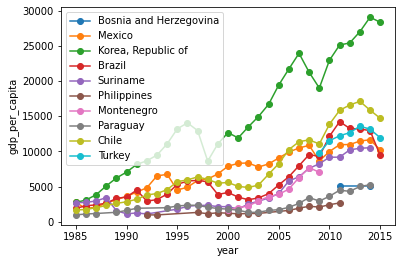

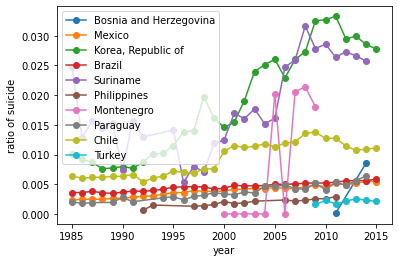

In [20]:
city_list = list({a:b for a,b in positive_relation.items()})
for country in city_list[:10]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("gdp_per_capita")
plt.legend()
plt.show()

for country in city_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("ratio of suicide")
plt.legend()
plt.show()

###### Last but not least, how about the countries with high suicide rate not related to the gdp_per_capita!? Let's see which countries meet the condition.

In [21]:
without_relation_gdp = {a:b for a,b in corr_eff.items() if -0.3 < b < 0.3}
no_relation_gdp = [i for i in country_list[:20] if i in without_relation_gdp.keys()]
no_relation_gdp

['Japan', 'Mongolia']

### In Summary:
###### Firstly, the suicide rate is related to several factors. First, national GDP per person. We have seen that the suicide rate in many countries is highly correlated with the gdp of the whole country, which shows that the degree of national wealth has a certain degree of reduction in suicide rate.

###### Second, the age. According to the suicide rate of each level of age, the rate of elderly is higher, so young people should care more about the elderly. Moreover, the country welfare of the elderly may also impact the rate.

###### Third, the social pressure. A healthy society can make citizens feel safe and satisfied, so how to relieve the social pressure becomes a significant topic for every country. Our purpose is not only reduce the suicide rate but also to build a better world.

### Now, let us build a simple model for prediction

In [22]:
df["HDI_for_year"].isnull().sum()

19456

In [23]:
df["generation"].nunique()

6

In [24]:
df.isnull().sum()

country                  0
year                     0
sex                      0
age                      0
suicides_no              0
population               0
suicides/100k_pop        0
country-year             0
HDI_for_year         19456
gdp_for_year             0
gdp_per_capita           0
generation               0
dtype: int64

In [25]:
df

,country,year,sex,age,suicides_no,population,suicides/100k_pop,country-year,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,63067077179,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,63067077179,2309,Silent
27817,Uzbekistan,2014,male,05-14 years,60,2762158,2.17,Uzbekistan2014,0.675,63067077179,2309,Generation Z
27818,Uzbekistan,2014,female,05-14 years,44,2631600,1.67,Uzbekistan2014,0.675,63067077179,2309,Generation Z


In [26]:
df1 = df.drop(["suicides/100k_pop", "country-year", "HDI_for_year"], axis=1)

In [27]:
df["age"].nunique()

6

In [28]:
features = df1.drop("suicides_no", axis=1)
target = df1["suicides_no"]

print(features.shape)
print(target.shape)

(27820, 8)
(27820,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 42)

In [30]:
features.dtypes

country           object
year               int64
sex               object
age               object
population         int64
gdp_for_year       int64
gdp_per_capita     int64
generation        object
dtype: object

In [31]:
def pipeline_transformer(data):
    cat_cols = list(data.select_dtypes(include=['O']).columns)
    num_cols = list(data.select_dtypes(include=['number']).columns)
    
    num_pipe_1 = make_pipeline(StandardScaler())
#     num_pipe_2 = make_pipeline(MinMaxScaler())

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                                      ("num_transform", num_pipe_1, num_cols),
                                    ]
#         , 'passthrough'
    )
    

    return column_transformer

In [32]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 42)


features_xfm = pipeline_transformer(X_train)
x_train_prepared = features_xfm.fit_transform(X_train)
x_test_prepared = features_xfm.transform(X_test)

In [33]:
x_train_prepared

<20865x119 sparse matrix of type '<class 'numpy.float64'>'
	with 166920 stored elements in Compressed Sparse Row format>

In [34]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train_prepared, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [35]:
y_pred = regr.predict(x_test_prepared)

In [36]:
y_pred

array([ 79.63937712,  79.63937712,  79.63937712, ..., 645.43540329,
       135.44564646, 127.14596614])

In [37]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(y_test,y_pred)

print("Results of regression metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of regression metrics:
MAE: 214.1105463140535
MSE: 381628.7386555904
RMSE: 617.7610692295124
R-Squared: 0.4845169602423042


In [38]:
params = {'learning_rate': 0.02090326662037724, 'reg_lambda': 2.619566541764405e-07, 'reg_alpha': 2.424490618732127e-06, 'subsample': 0.6599888744327127, 'colsample_bytree': 0.14519090292037226, 'max_depth': 3}
    
model = XGBRegressor(random_state=0, n_estimators=5000, #15000
                     **params)
model.fit(x_train_prepared, y_train, verbose=1000)
test_preds = model.predict(x_test_prepared)
xg_rmse = mean_squared_error(y_test, test_preds, squared=False)

In [39]:
x_mae = mean_absolute_error(y_test, test_preds)
x_mse = mean_squared_error(y_test, test_preds)
x_rmse = np.sqrt(mse) # or mse**(0.5)  
x_r2 = r2_score(y_test,test_preds)


print("Results of xgboost metrics:")
print("MAE:",x_mae)
print("MSE:", x_mse)
print("RMSE:", x_rmse)
print("R-Squared:", x_r2)
print(xg_rmse)

Results of xgboost metrics:
MAE: 87.0812914563288
MSE: 66027.73915286556
RMSE: 617.7610692295124
R-Squared: 0.9108133737339836
256.95863315496047


In [40]:
y_pred2 = regr.predict(x_test_prepared)

In [41]:
y_pred2

array([ 79.63937712,  79.63937712,  79.63937712, ..., 645.43540329,
       135.44564646, 127.14596614])

##### so we stick with the random forest regression